In [1]:
import numpy as np
import pandas as pd
from skimage import io, transform, img_as_float, color, transform
from skimage.io import imread, imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import time
from vgg19 import Vgg19

In [2]:
IMG_SIZE = (224, 224)

def load_img(path):
    img = img_as_float(io.imread(path))
    if len(img.shape) != 3:
        img = color.gray2rgb(img)
    
    if img.max() > 1:
        img /= 255
    h, w, _ = img.shape
    img = img[(h - min(h, w)) // 2: h - (h - min(h, w)) // 2, (w - min(h, w)) // 2: w - (w - min(h, w)) // 2, :]
    return transform.resize(img, IMG_SIZE + (3,))

def rotate_img(img, angle=10):
    shift_y, shift_x = np.array(img.shape[:2]) / 2.
    tf_rotate = transform.SimilarityTransform(rotation=(np.pi * angle / 180))
    tf_shift = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
    tf_shift_inv = transform.SimilarityTransform(translation=[shift_x, shift_y])

    image_rotated = transform.warp(img, (tf_shift + (tf_rotate + tf_shift_inv)).inverse)
    return image_rotated

In [3]:
BP = './data/finetuning-train/'
df = pd.read_csv(BP + 'gt.csv')
images = np.array(list(map(lambda a: load_img(BP + 'images/' + a), df['filename'])))

In [4]:
angles = [10, -10]
X = np.concatenate([images, list(map(lambda a: np.fliplr(a), images))])
# for a in angles:
#     rotate_foo = np.vectorize(rotate_img, otypes=[np.ndarray], excluded=['angle'])
#     rotated_images = rotate_foo(images, angle=a)
#     X.append(rotated_images)
#     X.append(list(map(lambda a: np.fliplr(a), rotated_imgs)))
# X = np.stack(np.concatenate(np.array(X)))

In [5]:
y = df['class_id'].values
y = np.concatenate([y, y])

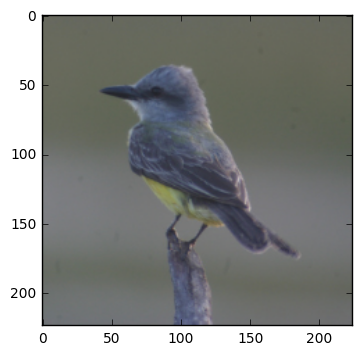

In [23]:
plt.imshow(X[2500])
plt.show()

### Load vgg weights

In [7]:
vgg19 = Vgg19(vgg19_npy_path="model/vgg19.npy")

npy file loaded


In [8]:
input_batch = tf.placeholder(tf.float32, shape=[None, IMG_SIZE[0], IMG_SIZE[1], 3])
vgg19.build(input_batch)

build model started
build model finished: 0s


In [9]:
sess = tf.InteractiveSession()
tf.initialize_all_variables().run(session=sess)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [11]:
def load_vgg_features(X, batch_size=128):
    features = []
    for i in range(0, X.shape[0], batch_size):
        features.append(sess.run(vgg19.fc6, feed_dict={input_batch: X[i: i + batch_size]}))
    return np.concatenate(np.array(features))

In [12]:
X_vgg = load_vgg_features(X)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_vgg, y, test_size=0.1)

### Finetuning with LogReg

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(dual=True)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
accuracy_score(y_val, clf.predict(X_val))

0.95999999999999996

## Prediction on test

In [18]:
BP = './data/finetuning-test/'
X_test = np.array(list(map(lambda a: load_img(BP + 'images/' + '0' * (4 - len(str(a))) + str(a) + '.png'), range(500))))

In [19]:
X_test_vgg = load_vgg_features(X_test)

In [20]:
y_pred = clf.predict(X_test_vgg)

In [22]:
pd.DataFrame(data={"filename": list(map(lambda x: str(x).zfill(4) + ".png", np.arange(500))),
                   "class_id": y_pred}, columns=["filename", "class_id"]).to_csv("sonya_best.csv", index=False)